In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(os.path.dirname(project_root))

# Summer month

results_basecase_summer = pd.read_csv(os.path.join(data_dir, 'results_basecase_summer.csv'),sep=',')
results_case_2_summer = pd.read_csv(os.path.join(data_dir,'results_case_2_summer.csv'), sep=',')
results_case_3_summer = pd.read_csv(os.path.join(data_dir,'results_case_3_summer.csv'), sep=',')


In [19]:
#print column names of all the dfs
#print('results_basecase_summer' , results_basecase_summer.head())
#print('results_case_2_summer' , results_case_2_summer.columns)
#print('results_case_3_summer' , results_case_3_summer.columns)#

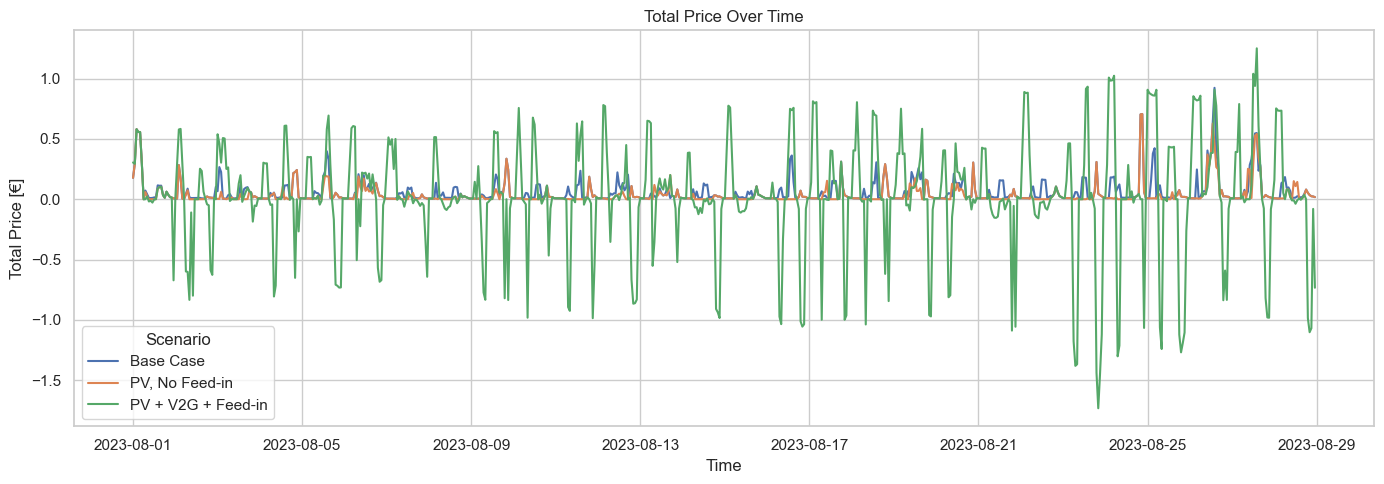

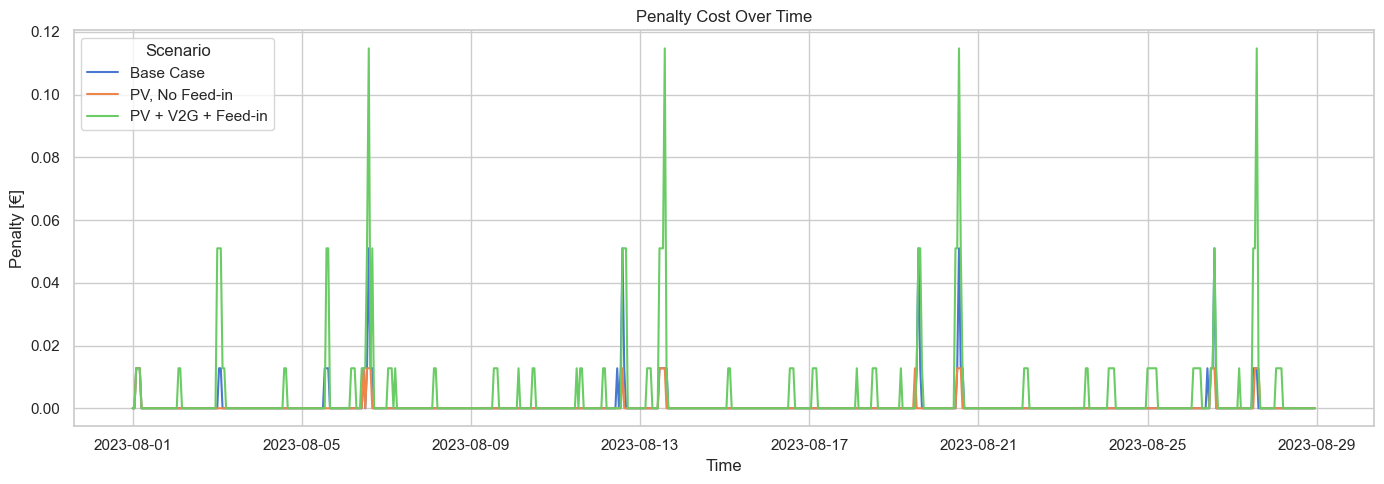

/var/folders/zr/7bf2xpyx49d4nx1_77v7ygqm0000gn/T/ipykernel_75642/1922830978.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined, x='Case', y='Net_Price', palette='pastel')


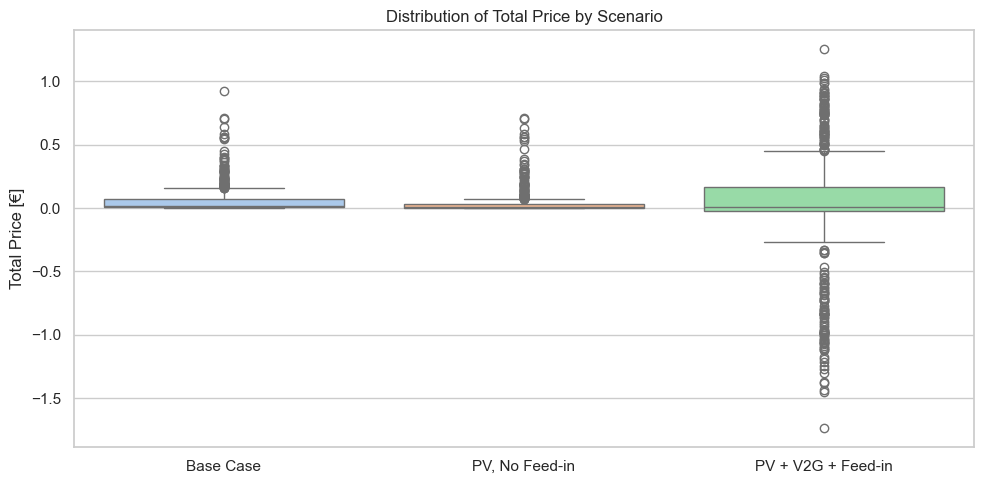

/var/folders/zr/7bf2xpyx49d4nx1_77v7ygqm0000gn/T/ipykernel_75642/1922830978.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unmet_total, x='Case', y='Unmet', palette='dark')


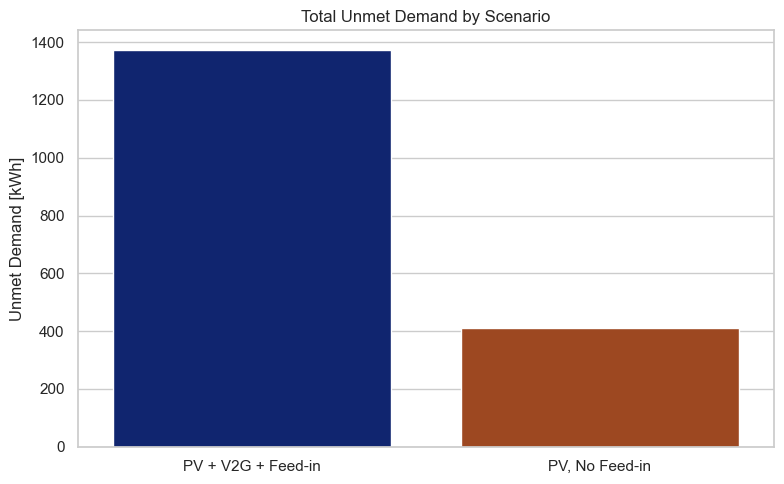

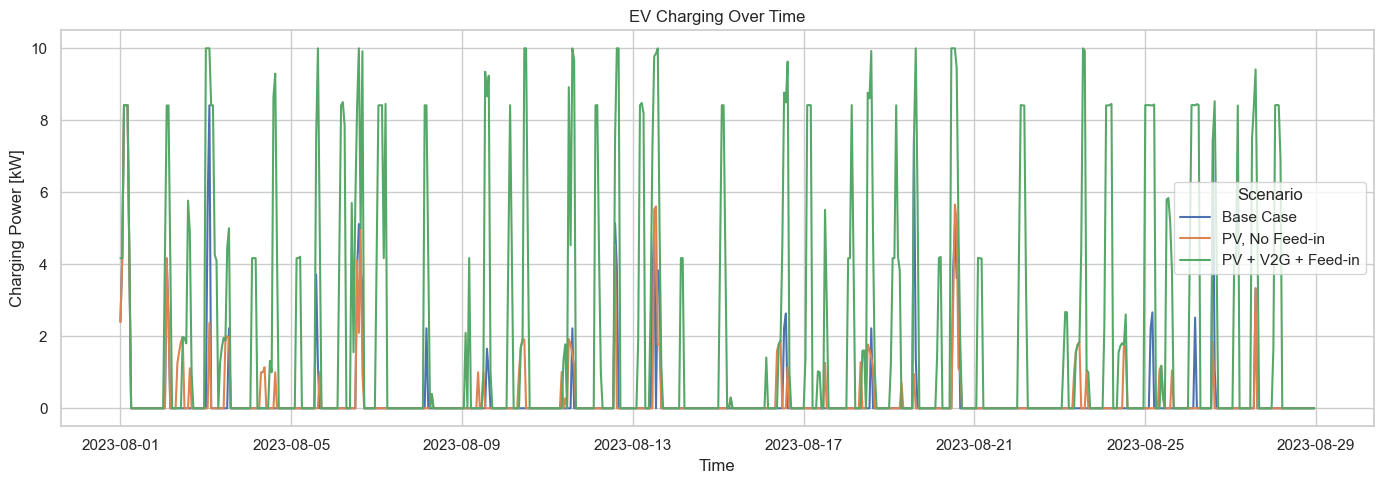

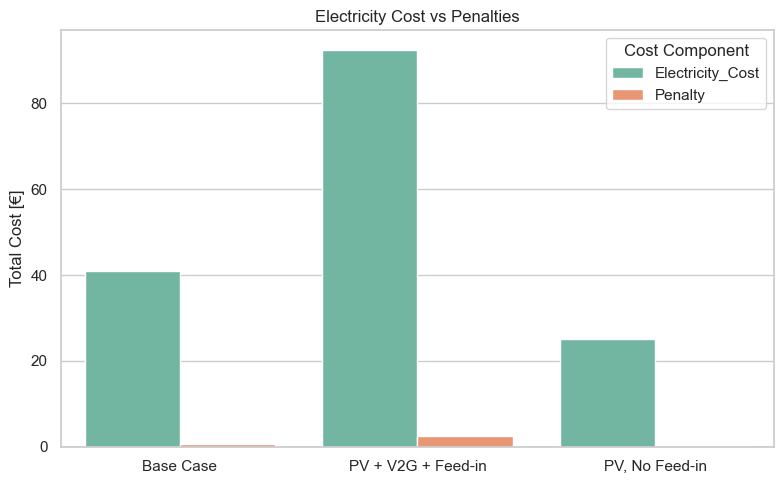

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Add case labels to each DataFrame
results_basecase_summer['Case'] = 'Base Case'
results_case_2_summer['Case'] = 'PV, No Feed-in'
results_case_3_summer['Case'] = 'PV + V2G + Feed-in'

# Normalize column naming for uniformity
results_basecase_summer = results_basecase_summer.rename(columns={'Total_Cost': 'Net_Price', 'Penalty_Cost': 'Penalty'})
results_case_2_summer = results_case_2_summer.rename(columns={'Total_Price': 'Net_Price'})
results_case_3_summer = results_case_3_summer.rename(columns={'Net_Price': 'Net_Price'})

# Combine all into a single DataFrame
combined = pd.concat([results_basecase_summer, results_case_2_summer, results_case_3_summer], ignore_index=True)

# Convert timestamp to datetime (if not already)
combined['timestamp'] = pd.to_datetime(combined['timestamp'])
combined['Hour'] = combined['timestamp'].dt.hour
combined['Day'] = combined['timestamp'].dt.date
combined['Weekday'] = combined['timestamp'].dt.day_name()

# ----- 1. Time Series Plot: Total Price over Time -----
plt.figure(figsize=(14, 5))
sns.lineplot(data=combined, x='timestamp', y='Net_Price', hue='Case', palette='deep')
plt.title('Total Price Over Time')
plt.xlabel('Time')
plt.ylabel('Total Price [€]')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

# ----- 2. Time Series Plot: Penalty Cost over Time -----
plt.figure(figsize=(14, 5))
sns.lineplot(data=combined, x='timestamp', y='Penalty', hue='Case', palette='muted')
plt.title('Penalty Cost Over Time')
plt.xlabel('Time')
plt.ylabel('Penalty [€]')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

# ----- 3. Distribution Plot: Total Price -----
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined, x='Case', y='Net_Price', palette='pastel')
plt.title('Distribution of Total Price by Scenario')
plt.ylabel('Total Price [€]')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ----- 4. Bar Plot: Total Unmet Demand (only where available) -----
unmet_df = combined.dropna(subset=['Unmet'])
unmet_total = unmet_df.groupby('Case')['Unmet'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=unmet_total, x='Case', y='Unmet', palette='dark')
plt.title('Total Unmet Demand by Scenario')
plt.ylabel('Unmet Demand [kWh]')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ----- 5. EV Charging Pattern -----
plt.figure(figsize=(14, 5))
sns.lineplot(data=combined, x='timestamp', y='EV_Charging', hue='Case', linewidth=1.5)
plt.title('EV Charging Over Time')
plt.ylabel('Charging Power [kW]')
plt.xlabel('Time')
plt.legend(title='Scenario')
plt.tight_layout()
plt.show()

# ----- 6. Energy Cost Breakdown -----
cost_components = ['Electricity_Cost', 'Penalty']
summary = combined.groupby('Case')[cost_components].sum().reset_index()
summary_melted = summary.melt(id_vars='Case', var_name='Component', value_name='Cost')

plt.figure(figsize=(8, 5))
sns.barplot(data=summary_melted, x='Case', y='Cost', hue='Component', palette='Set2')
plt.title('Electricity Cost vs Penalties')
plt.ylabel('Total Cost [€]')
plt.xlabel('')
plt.legend(title='Cost Component')
plt.tight_layout()
plt.show()
